In [1]:
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd 

data = pd.read_csv("./dataset/hmnist_28_28_RGB.csv")
data.head()
meta_df = pd.read_csv("./dataset/HAM10000_metadata.csv")
meta_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [2]:
meta_df.shape
data.shape

(10015, 2353)

In [3]:
yData = data['label']
XData = data.drop(columns = ['label'])
# EDA
distribution = meta_df['dx'].value_counts()
distribution
# classes = {4: ('nv', ' Nevus'),
#            6: ('mel', 'Melanoma'),
#            2 :('bkl', 'Seborrheic Keratosis'), 
#            1:('bcc' , ' Basal Cell Carcinoma '),
#            5: ('vasc', 'Vascular Lesion'),
#            0: ('akiec', 'Actinic Keratosis'),
#            3: ('df', 'Dermatofibroma')}

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

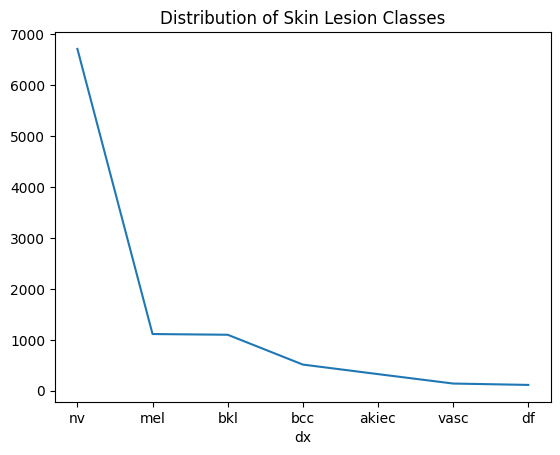

In [4]:
dist = data['label'].value_counts()
dist
distribution.plot()
plt.title('Distribution of Skin Lesion Classes')
plt.show()

In [5]:
# Fixing Data Imbalance
from imblearn.over_sampling import RandomOverSampler 
sampler = RandomOverSampler()
XData,yData  = sampler.fit_resample(XData,yData)
XData.shape, yData.shape
XData = np.array(XData).reshape((-1, 28, 28, 3))
XData = XData / 255
XData.shape

(46935, 28, 28, 3)

In [6]:
# Creating the train and validation set
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(XData,yData, test_size=0.2)
Xtrain.shape, Xtest.shape

((37548, 28, 28, 3), (9387, 28, 28, 3))

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, SeparableConv2D
from tensorflow.keras.layers import Conv2DTranspose, ZeroPadding2D, SpatialDropout2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

input_shape = (28, 28, 3) 
num_classes = 7

# Custom CNN

In [9]:
# Convolution Block
def conv_block(x, filters, kernel_size, strides=1, padding='same'):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

# Identity Block (used in ResNet for residual connections)
def identity_block(x, filters):
    skip = x
    x = conv_block(x, filters, 3)
    x = conv_block(x, filters, 3)
    x = layers.Add()([x, skip])
    return x

# Dense Block (used in DenseNet)
def dense_block(x, num_layers, growth_rate):
    for i in range(num_layers):
        layer = conv_block(x, growth_rate, 3)
        x = layers.Concatenate()([x, layer])
    return x

# Transition Block (used in DenseNet to reduce dimensions)
def transition_block(x, filters):
    x = layers.Conv2D(filters, 1, padding='same')(x)
    x = layers.AvgPool2D(pool_size=2, strides=2, padding='same')(x)
    return x

# Define the Hybrid CNN model
def hybrid_cnn_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial Convolution and Pooling layers
    x = conv_block(inputs, 64, 7, strides=2)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Conv Block A, B, and C (Conv blocks can be repeated with different filters)
    x = conv_block(x, 64, 3)
    x = conv_block(x, 128, 3)
    x = conv_block(x, 256, 3)

    # Adding an Identity Block (ResNet style)
    x = identity_block(x, 256)

    # Transition Block
    x = transition_block(x, 128)

    # Dense Block (Growth rate 32 and 6 layers in this example)
    x = dense_block(x, 6, 32)

    # Pooling (Averaging)
    x = layers.GlobalAveragePooling2D()(x)

    # Fully Connected (FC) Layer
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output Layer with Softmax for multi-class classification
    outputs = layers.Dense(7, activation='softmax')(x)

    # Create the model
    model = models.Model(inputs, outputs)

    return model


HybridCNN = hybrid_cnn_model(input_shape, num_classes)

HybridCNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
history = HybridCNN.fit(Xtrain,
                    Ytrain,
                    epochs = 20,
                    validation_data = (Xtest, Ytest))

Epoch 1/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 145s 118ms/step - accuracy: 0.4846 - loss: 1.3452 - val_accuracy: 0.5635 - val_loss: 1.2087
Epoch 2/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 143s 122ms/step - accuracy: 0.7004 - loss: 0.8149 - val_accuracy: 0.5201 - val_loss: 1.5395
Epoch 3/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 145s 124ms/step - accuracy: 0.7695 - loss: 0.6246 - val_accuracy: 0.2940 - val_loss: 5.3182
Epoch 4/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 146s 124ms/step - accuracy: 0.8184 - loss: 0.5043 - val_accuracy: 0.6612 - val_loss: 0.9996
Epoch 5/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 147s 125ms/step - accuracy: 0.8496 - loss: 0.4087 - val_accuracy: 0.6760 - val_loss: 1.1096
Epoch 6/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 150s 128ms/step - accuracy: 0.8744 - loss: 0.3377 - val_accuracy: 0.6300 - val_loss: 2.2067
Epoch 7/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 169s 144ms/step - accuracy: 0.8948 - loss: 0.2875 - val_accuracy: 0.7903 - val_loss: 0.6550
Epoch 8/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 207s 177ms/step - ac

In [11]:
from tabulate import tabulate

loss_hybrid_cnn, accuracy_hybrid_cnn = HybridCNN.evaluate(Xtest, Ytest)

table = [["\033[1mTest Accuracy\033[0m", "{:.2f}%".format(accuracy_hybrid_cnn * 100)],
         ["\033[1mTest Loss\033[0m", "{:.4f}".format(loss_hybrid_cnn)]]

print(tabulate(table, tablefmt="grid"))

294/294 ━━━━━━━━━━━━━━━━━━━━ 25s 84ms/step - accuracy: 0.7646 - loss: 1.1660
+---------------+--------+
| Test Accuracy | 76.55% |
+---------------+--------+
| Test Loss     | 1.1699 |
+---------------+--------+


In [12]:
from tabulate import tabulate

loss_hybrid_cnn, accuracy_hybrid_cnn = HybridCNN.evaluate(Xtest, Ytest)

table = [["\033[1mTest Accuracy\033[0m", "{:.2f}%".format(accuracy_hybrid_cnn * 100)],
         ["\033[1mTest Loss\033[0m", "{:.4f}".format(loss_hybrid_cnn)]]

print(tabulate(table, tablefmt="grid"))

294/294 ━━━━━━━━━━━━━━━━━━━━ 21s 72ms/step - accuracy: 0.7646 - loss: 1.1660
+---------------+--------+
| Test Accuracy | 76.55% |
+---------------+--------+
| Test Loss     | 1.1699 |
+---------------+--------+


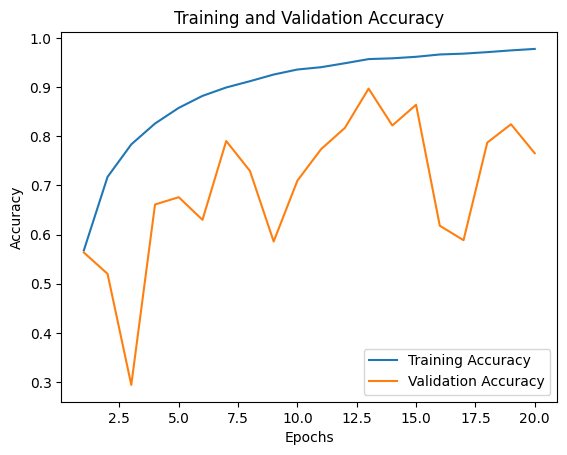

In [14]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

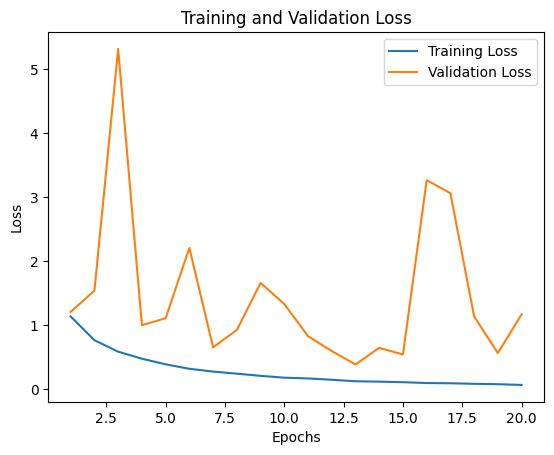

In [13]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()